In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import comet_ml
import torch
from torchvision import transforms
from rsl_depth_completion.diffusion.utils import set_seed

from pathlib import Path
import shutil
import numpy as np

from kbnet import data_utils
import yaml
import argparse
from utils import plot_sample
import tensorflow as tf
from pathlib import Path
from torchvision.utils import save_image
from tqdm.auto import tqdm
from PIL import Image
import torch.optim as optim


%matplotlib inline

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


In [9]:
from rsl_depth_completion.conditional_diffusion.config import device, is_cluster, tmpdir, experiment, timesteps

In [10]:
if is_cluster:
    if not os.path.exists(f'{tmpdir}/cluster'):
        !tar -xvf /cluster/project/rsl/kzaitsev/datasets.tar -C $TMPDIR

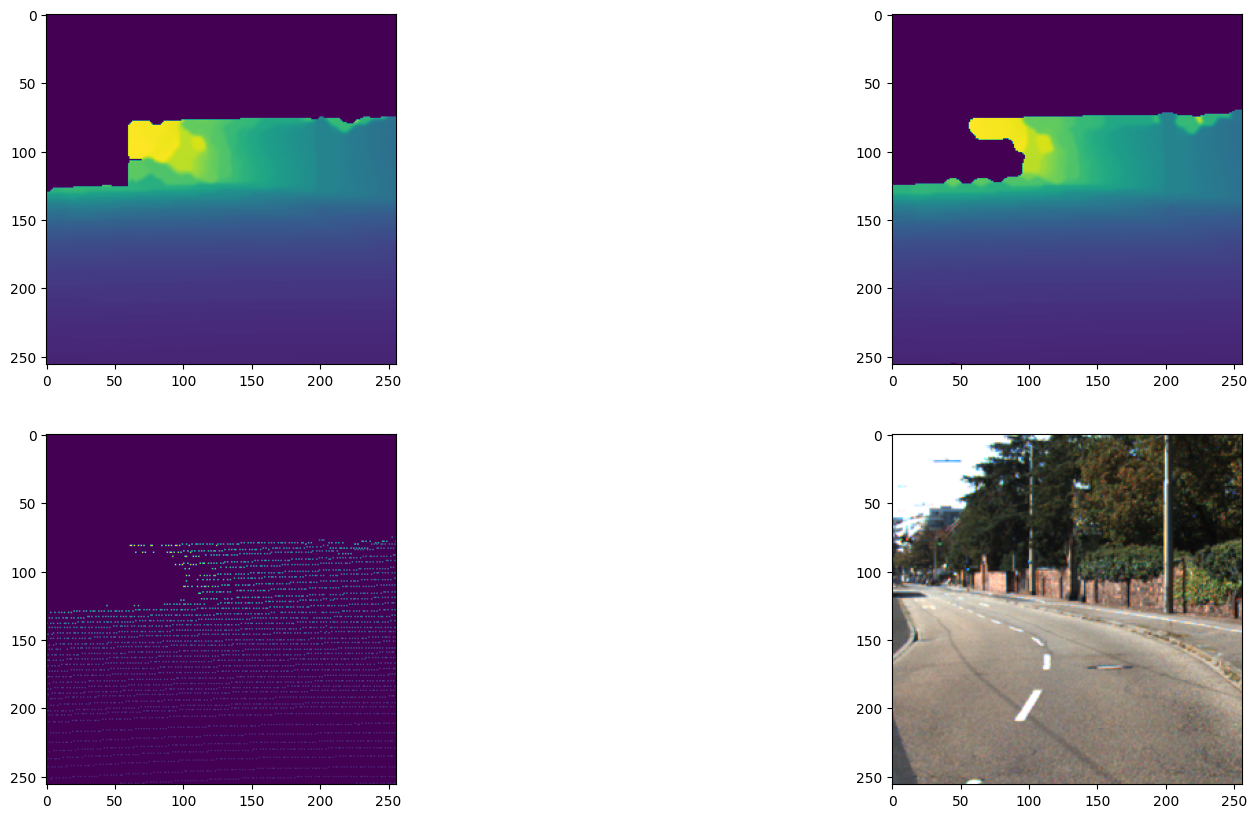

(torch.Size([1, 256, 256]),
 torch.Size([1, 512]),
 torch.Size([1, 512]),
 torch.Size([3, 256, 256]))

In [11]:
from load_data import ds, train_dataloader, valid_dataloader

x = ds[0]
plot_sample(x)
x["perturbed_sdm"].shape, x["rgb_embed"].shape, x["sdm_embed"].shape, x[
    "rgb_image"
].shape

In [12]:
len(train_dataloader), len(valid_dataloader)

(200, 50)

In [14]:
from model import unet_base, imagen

import gc

gc.collect()
torch.cuda.empty_cache()


unet_base.to(device)
imagen.to(device)

print(
    "Number of parameters in model",
    sum(p.numel() for p in imagen.parameters() if p.requires_grad),
)

The base dimension of your u-net should ideally be no smaller than 128, as recommended by a professional DDPM trainer https://nonint.com/2022/05/04/friends-dont-let-friends-train-small-diffusion-models/
Number of parameters in model 29305346


In [15]:
lr = 5e-6

optimizer = optim.Adam(imagen.parameters(), lr=lr)

In [21]:
logdir = Path("./logs")

input_name = "interp_sdm"
cond = "rgb+sdm"
# exp_dir = f"{input_name=}/{cond=}/{lr=}_{timesteps=}"
# train_logdir = logdir / "train" / exp_dir
do_debug = True

debug_dir = logdir / "debug"
exp_dir = f"{len(os.listdir(debug_dir)) + 1:03d}"
train_logdir = debug_dir / exp_dir
train_logdir.mkdir(parents=True, exist_ok=True)
train_writer = tf.summary.create_file_writer(str(train_logdir))

Epoch 1:  19%|█▉        | 4/21 [01:14<05:42, 20.12s/it, loss=1.98]

Epoch: 1	{'loss': 1.9821631908416748}


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

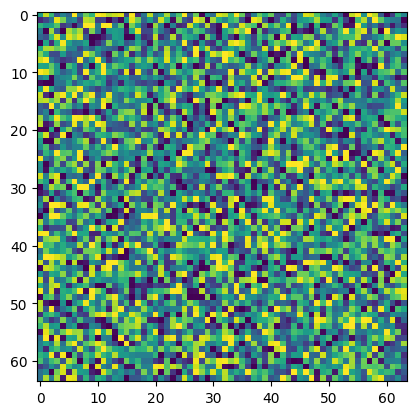

In [22]:
from train import train

train(
    imagen,
    optimizer,
    train_dataloader,
    do_debug=do_debug,
    out_dir=train_logdir,
    train_writer=train_writer,
)

In [ ]:
experiment.end()